# A function to match the DM delays of the FDMT

In [15]:
from pylab import *
import matplotlib as mpl
import numpy as np
from scipy import constants
from craft import fdmt # you'll need to have ../python in  you PYTHONPATH
print(sys.path)

%matplotlib inline

['/opt/xilinx/xrt/python', '/data/craco/ban115/craft-github/notebooks', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages', '/data/craco/ban115/realtime_pipeline_master/python/craco_testing/src', '/data/craco/ban115/craft-github/src', '/data/craco/ban115/realtime_pipeline_master/python/craco_pybind11', '/data/craco/ban115/realtime_pipeline_master/roce_packetizer/pybind11', '/data/craco/ban115/python-rdma-transport', '/data/craco/ban115/Furby_p3', '/data/craco/ban115/Furby_injector', '/data/craco/ban115/craco-python/src', '/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/IPython/extensions', '/home/ban115/.ipython']


In [39]:
fc = 990.5 # center frequency GHz
bw = 0.288 # bandwidth GHz
Nd = 512 # number of DM trials
Nchan= 256
Nt = 256 # time block size
Tint = 0.864e-3 # integration time - seconds
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']
f1 = 0.7355
chanbw = 1e-3
lam1 = constants.c/f1/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2

In [40]:
import importlib
importlib.reload(fdmt)
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)


In [41]:
def frbdelay(thefdmt, idt):
    '''
    Returns the delays for all the channels of the given FDMT for an FRB 
    with a given DM (idt)
    :thefdmt: FDMT class
    :idt: Value of the DM in units of samples
    '''
    fch1 = thefdmt.f_min
    nchan = thefdmt.n_f
    foff = thefdmt.d_f
    freqs = np.arange(nchan)*foff + fch1
    fmin = freqs.min() - 0.5*foff*0
    fmax = freqs.max() + 0.5*foff*0
    

    # cff is the relative amount of delay between the channels of interest and over teh whole band.
    cff = (freqs ** -2 - fmin**-2)/(fmax**-2 - fmin**-2)
    
    # this is what Barak calculates
    #delta_t = np.ceil((float(idt) - 1.0)*cff) + 1
    
    # Thisis my implementation of barak's delta t
    #delta_t = np.array([fdmt.calc_delta_t( fmin, fmax, fmin, f, idt) for f in freqs])
    
    # This is what makes sense to me - maybe with some rounding in there in the end
    delta_t = (float(idt)*cff) 

        
    return delta_t

def plot_trace(thefdmt, idt):
    
    # Trace DM goes backwards through the FDMT and works out what delays were used.
    # I can make an FRB with the exact delays that trace_dm() returns
    # and I get a hitting efficiency of 100% - so I know that works.
    dmtrace = np.array(thefdmt.trace_dm(idt))
    
    channels = dmtrace[:, 0]
    widths = dmtrace[:, 1]
    fdmtdelays = dmtrace[:, 2]
    
    frbdelays = frbdelay(thefdmt, idt)
    delaydiff = frbdelays - fdmtdelays
    if np.all(np.round(delaydiff) == 0):
        print('delays equal')
    else:
        print("****** WARNING DELAYS NOT EQUAL!!!!! *****")
        
    if False:
        plot(channels, delays, 'bx')
        plot(channels, testdelays, 'r+')
    else:
        fig, ax = subplots(2,1, sharey=True, figsize=(12,6))
        ax = ax.flatten()
        ax[0].set_title('Delays')
        ax[0].plot(fdmtdelays, channels, 'x')
        ax[0].plot(frbdelays, channels, 'r+')
        ax[1].plot(delaydiff, channels , 'x')
        ax[1].axvline(0.5)
        ax[1].axvline(-0.5)
        ax[1].set_xlabel('Delay (samples)')
        ax[1].set_xlabel('Delay error (samples)')
        ax[0].set_ylabel('channel')
        ax[1].set_ylabel('Channel')

        

****** WARNING DELAYS NOT EQUAL!!!!! *****


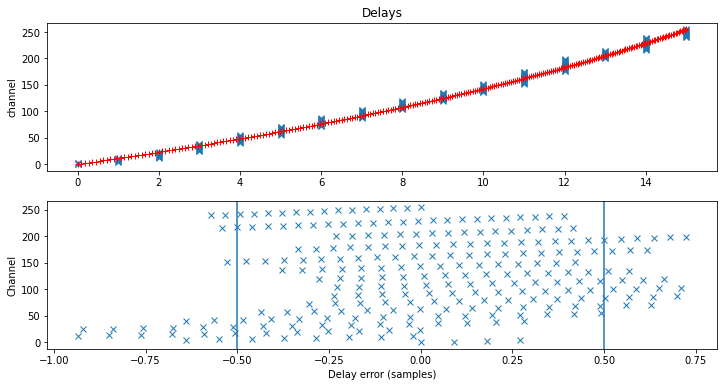

In [47]:
idt = 15

plot_trace(thefdmt, idt)

Text(0, 0.5, 'time')

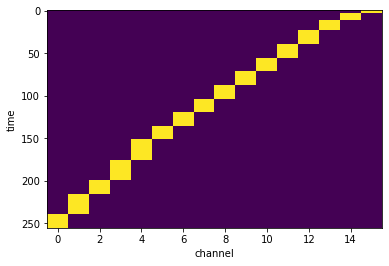

In [52]:
figure()
imshow(thefdmt.add_frb_track(idt), aspect='auto', origin='upper', interpolation='none')
xlabel('channel')
ylabel('time')

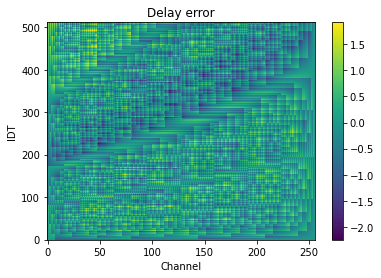

In [43]:
# Check every value of IDT and see what the delay errors look like
fdmttraces = []
frbdelays = []


for idt in range(thefdmt.max_dt):
    dmtrace = np.array(thefdmt.trace_dm(idt))
    fdmttraces.append(dmtrace)
    frbdelays.append(frbdelay(thefdmt, idt))

fdmttraces = np.array(fdmttraces)
frbdelays = np.array(frbdelays)
delaydiffs = frbdelays - fdmttraces[:,:,2] 
imshow(delaydiffs, aspect='auto', origin='lower', interpolation='nearest')
xlabel('Channel')
ylabel('IDT')
title('Delay error')
colorbar()

Text(0, 0.5, 'Delay difference (samples)')

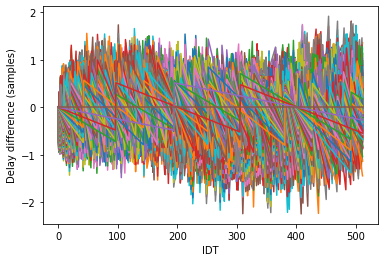

In [44]:
_ = plot(delaydiffs)
xlabel('IDT')
ylabel('Delay difference (samples)')